# Survival Analysis

## Intuition

Imagine we are a pharma company and we came up with a new drug that we believe cures cancer. To test our drug, we start a clinical trial with patients that have cancer, and randomly split them to 2 groups and tell both groups that they are taking the drug.

1. Group 1 take the actual drug.
2. Group 2 think they are taking the actual drug but in reality take a placebo i.e. saline solution.

This setup ensures that there are no psychological effects.

We start recording the times at which a death happens in both groups, and at the end of study we start analysing the data to determine the effect of our drug. For our drug to work, there needs to be a significant difference in the survival probability between the 2 groups.

We calculate the probability of survival for both groups at each time point and we end up with a **Kaplan Meier** plot to visualize the result.

![Kaplan Meier plot](km.png "Kaplan Meier plot")

Our drug seems to work! The probability of survival for the group taking the drug is higher than the other group. However, there is huge caveat. We did not take into account other variables that may affect the survival of patients. Maybe, females responded well to the drug and the placebo group had no females, or the placebo group had higher diabetes. We call these confounders that we need to take into account.

## Cox Proportional Hazards

Our motivation is to quantify the effect of variables on patient survival and determine the dominating variable on patient survival.

The Cox proportional hazards model assumes that:
1. The relationship between *log(hazard)* and the variables are linear.
2. Hazard ratio is constant over time.

and the hazard function, $h_i(t)$ for the failure time $t$ of an individual $i$ with a vector of variables $x$ is as follows:

$$h_i(t)=h_o(t)exp(x_i^T\beta)$$

where $h_o(t)$ is the unknown baseline hazard. We calculate the partial likelihood function to estimate the coefficients. Since the hazard ratio, $\frac{h_i(t)}{h_o(t)}={constant}$, we do not need to know the baseline hazard while calculating the likelihood.
$$L(\beta) = \prod_j{exp(x_j^T\beta)\over\sum_{i\in R(t_j)}{exp(x_j^T\beta)}}$$

where $j$ indexes the observed death times and $R(t)$ is the set of samples at risk at time $t$.


Our goal is to estimate the coefficients that maximize the likelihood function. This problem can be solved using different optimizers, the method used in this notebook is **Newton-Raphson Method**. 

Variables with positive coefficients increase the risk of death, meanwhile, negative coefficients have a protective effect. The significance of each coefficient is calculated using a ***t-test***, while the model's significance is calculated using ***Chi squared goodness of fit test*** where:
$$X^2=\sum{(observed-expected)^2\over expected}$$

## Example

The dataset consists of survival data of 88 patients with a certain type of cancer. Each patient is described by:
1. Dead or not (Overall Survival)
2. Time of death or End of Study (Overall Survival Time)
3. Age
4. Gender
5. Total number of sick cells
6. Has sick cells that reduce immunity

In [21]:
%matplotlib inline

import lifelines
import lifelines.statistics
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

sns.set_style()
# plt.rcParams["figure.dpi"] = 1200
# plt.rcParams['figure.figsize'] = [8, 4]

In [22]:
df = pd.read_csv("OS/OS.maf",sep="\t",header=0)
df["OS.time"] = df["OS.time"] // 30
df["gender"].replace({0:"FEMALE",1:"MALE"},inplace=True)
df["MRM_Status"] = df["MRM_Count"].astype(str).copy()
df["MRM_Status"].replace("0","NO",inplace=True)
df["MRM_Status"].replace(r"[0-9]+",value="YES",regex=True,inplace=True)
df = df[df["Cancer_Type"] == "ACC"][["Patient_Barcode","OS", "OS.time","age_at_initial_pathologic_diagnosis","gender","Total_Count","MRM_Status"]]
df = df.rename(columns={"MRM_Status":"has_immunity_sick_cells","Total_Count":"total_sick_cells","age_at_initial_pathologic_diagnosis":"age"})
print(f"Number of patients: {df.shape[0]}")
df.head(8)

Number of patients: 88


,Patient_Barcode,OS,OS.time,age,gender,total_sick_cells,has_immunity_sick_cells
1330,TCGA-PK-A5HC,0,22,44.0,FEMALE,87,NO
1331,TCGA-PK-A5HB,0,43,63.0,MALE,1590,YES
1332,TCGA-PK-A5HA,0,40,63.0,MALE,75,YES
1333,TCGA-PK-A5H9,0,20,27.0,FEMALE,22,NO
1334,TCGA-PK-A5H8,0,120,42.0,MALE,33,NO
1349,TCGA-PA-A5YG,0,25,51.0,MALE,11,NO
1356,TCGA-P6-A5OH,1,0,59.0,FEMALE,177,YES
1357,TCGA-P6-A5OG,1,12,45.0,FEMALE,321,YES


### Univariate Model

#### Immunity Sick Cell Status

First, we check if the distribution of the dataset. Censored here can mean lots of things. It can mean:
1. The patient survived until the end of the data collection phase, here the time is the end of the study.
2. The researchers lost contact with the patient, here the time is the last contact date.

In [23]:
cnt = pd.DataFrame([
    [df[(df["has_immunity_sick_cells"] == "YES") & (df["OS"] == 1)].shape[0],df[(df["has_immunity_sick_cells"] == "NO") & (df["OS"] == 1)].shape[0],0],
    [df[(df["has_immunity_sick_cells"] == "YES") & (df["OS"] == 0)].shape[0],df[(df["has_immunity_sick_cells"] == "NO") & (df["OS"] == 0)].shape[0],0],
    [0,0,0]
],columns=["has_immunity_sick_cells","no_immunity_sick_cells","Total"],index=["Death","Censored","Total"])
cnt.loc["Total"] = cnt.sum()
cnt["Total"] = cnt.iloc[:,0:2].sum(1)
cnt.head()

,has_immunity_sick_cells,no_immunity_sick_cells,Total
Death,19,11,30
Censored,15,43,58
Total,34,54,88


Now, we use the data to estimate the coefficient, and determine the statistical significance of these results.

In [24]:
summ = None
cox = lifelines.CoxPHFitter()
cox.fit(df[["has_immunity_sick_cells","OS","OS.time"]],event_col= "OS", duration_col="OS.time",formula="C(has_immunity_sick_cells)")
cox.print_summary()
cox.check_assumptions(df[["has_immunity_sick_cells","OS","OS.time"]],False)

<lifelines.CoxPHFitter: fitted with 88 total observations, 58 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 30
   partial log-likelihood = -115.08
         time fit was run = 2024-02-14 15:57:41 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
C(has_immunity_sick_cells)[T.YES]   1.29       3.62       0.38             0.54             2.03                 1.71                 7.64

                                     z      p   -log2(p)
covariate                                               
C(has_immunity_sick_cells)[T.YES] 3.37 <0.005      10.38
---
Concordance = 0.67
Partial AIC = 232.17
log-likelihood ratio test = 11.92 on 1 df
-log2(p) of ll-ratio test = 10.81

Proportional hazard assumption looks okay.


[]

We would expect the presence of immunity sick cells to increase the risk of death, e.g. positive coefficients. As expected, the presence of the variable increases the hazard on patients and the small p-value confirms that this result is statistically significant.

Remember that our formula was:

$$h_i(t)=h_o(t)exp(x_i^T\beta)$$

and $x_i=1$ means that the patient has an immunity sick cell. So, the associated hazard is:
$$h_i(t)=h_o(t)exp(1 * 1.29)$$

since $h_o(t)$ is unknown, we can not calculate the hazard of this patient. However, we can calculate the hazard ratio of someone that has an immunity sick cell and someone who does not.

$$\frac{h_i}{h_j} = \frac{h_o(t)exp(1 * 1.29)}{h_o(t)exp(0 * 1.29)} = \frac{3.62}{1} = 3.62$$

This means that someone that with an immunity sick cell is **3.62** times more likely to die than someone who does not.

We evaluate the model by checking the *Concordance*, *Akaike information criterion (AIC)*, and the *Log Likelihood*. Here, our concordance is **67%** which describes how much our model fits the data. Also, the higher the log likelihood the better. 

#### Gender

Studies indicate that males have a higher risk of death for certain cancer types than females. Therefore, we expect to have a positive coefficent for males when compared to females.

In [25]:
cnt = pd.DataFrame([
    [df[(df["gender"] == "MALE") & (df["OS"] == 1)].shape[0],df[(df["gender"] == "FEMALE") & (df["OS"] == 1)].shape[0],0],
    [df[(df["gender"] == "MALE") & (df["OS"] == 0)].shape[0],df[(df["gender"] == "FEMALE") & (df["OS"] == 0)].shape[0],0],
    [0,0,0]
],columns=["Male","Female","Total"],index=["Death","Censored","Total"])
cnt.loc["Total"] = cnt.sum()
cnt["Total"] = cnt.iloc[:,0:2].sum(1)
cnt.head()

,Male,Female,Total
Death,9,21,30
Censored,21,37,58
Total,30,58,88


In [26]:
summ = None
cox = lifelines.CoxPHFitter()
cox.fit(df[["gender","OS","OS.time"]],event_col= "OS", duration_col="OS.time",formula="C(gender)")
cox.print_summary()
cox.check_assumptions(df[["gender","OS","OS.time"]],False)

<lifelines.CoxPHFitter: fitted with 88 total observations, 58 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 30
   partial log-likelihood = -120.84
         time fit was run = 2024-02-14 15:57:41 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
C(gender)[T.MALE]  -0.25       0.78       0.40            -1.03             0.53                 0.36                 1.71

                      z    p   -log2(p)
covariate                              
C(gender)[T.MALE] -0.62 0.53       0.90
---
Concordance = 0.52
Partial AIC = 243.69
log-likelihood ratio test = 0.40 on 1 df
-log2(p) of ll-ratio test = 0.92

Proportional hazard assumption looks okay.


[]

In our case, we have negative coeficients, however, the results are statistically insignificant. Also, the concordance is **52%** which is slightly better than a coin toss.

#### Age

First, we plot the visualize the data and check for skewness.

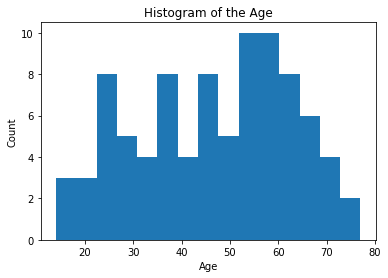

In [27]:
plt.hist(df['age'], bins=15)
plt.title("Histogram of the Age")
plt.xlabel("Age")
_ = plt.ylabel("Count")

We would expect that the risk of death is associated with increase in age.

In [28]:
summ = None
cox = lifelines.CoxPHFitter()
cox.fit(df[["age","OS","OS.time"]],event_col= "OS", duration_col="OS.time",formula="age")
cox.print_summary()
cox.check_assumptions(df[["age","OS","OS.time"]],False)

<lifelines.CoxPHFitter: fitted with 88 total observations, 58 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 30
   partial log-likelihood = -120.68
         time fit was run = 2024-02-14 15:57:41 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03

             z    p   -log2(p)
covariate                     
age       0.84 0.40       1.32
---
Concordance = 0.55
Partial AIC = 243.37
log-likelihood ratio test = 0.72 on 1 df
-log2(p) of ll-ratio test = 1.33

Proportional hazard assumption looks okay.


[]

Surprisingly, age seems to have no effect on survival.

#### Total Sick Cells

First, we plot the distribution of the data and check for normality. Clearly, the data is very skewed, hence, we apply log transformation.

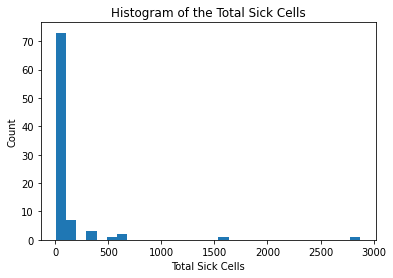

In [29]:
plt.hist(df['total_sick_cells'], bins=30)
plt.title("Histogram of the Total Sick Cells")
plt.xlabel("Total Sick Cells")
_=plt.ylabel("Count")

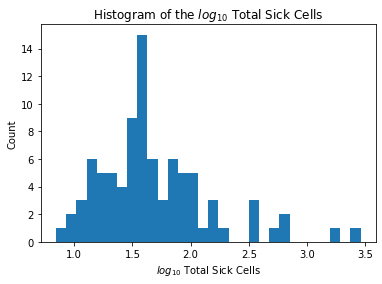

In [30]:
df['Log10_total_sick_cells'] = np.log10(df["total_sick_cells"])
plt.hist(df['Log10_total_sick_cells'], bins=30)
plt.title("Histogram of the $log_{10}$ Total Sick Cells")
plt.xlabel("$log_{10}$ Total Sick Cells")
_=plt.ylabel("Count")

We would expect the risk to increase when there is a big number of sick cells.

In [31]:
summ = None
cox = lifelines.CoxPHFitter()
cox.fit(df[["Log10_total_sick_cells","OS","OS.time"]],event_col= "OS", duration_col="OS.time",formula="Log10_total_sick_cells")
cox.print_summary()
cox.check_assumptions(df[["Log10_total_sick_cells","OS","OS.time"]],False)

<lifelines.CoxPHFitter: fitted with 88 total observations, 58 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 30
   partial log-likelihood = -114.16
         time fit was run = 2024-02-14 15:57:43 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Log10_total_sick_cells   1.19       3.27       0.29             0.62             1.75                 1.86                 5.76

                          z      p   -log2(p)
covariate                                    
Log10_total_sick_cells 4.10 <0.005      14.59
---
Concordance = 0.75
Partial AIC = 230.32
log-likelihood ratio test = 13.76 on 1 df
-log2(p) of ll-ratio test = 12.24

Proportional hazard assumption looks okay.


[]

Indeed, the increase in the number of sick cells increases the hazard and it is statistically significant. Since we are using the log scale this means that every increase of **10** sick cells increases the hazard by **3.29** times.

### Multivariate Model

So far we have been ignoring the interaction of variables with each other. Now, we can build a model using all variables.

In [32]:
summ = None
cox = lifelines.CoxPHFitter()
cox.fit(df[["Log10_total_sick_cells","gender","age","has_immunity_sick_cells","OS","OS.time"]],event_col= "OS", duration_col="OS.time",formula="Log10_total_sick_cells+age+has_immunity_sick_cells+C(gender)")
cox.print_summary()
cox.check_assumptions(df[["Log10_total_sick_cells","gender","age","has_immunity_sick_cells","OS","OS.time"]],False)

<lifelines.CoxPHFitter: fitted with 88 total observations, 58 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 30
   partial log-likelihood = -112.28
         time fit was run = 2024-02-14 15:57:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
C(gender)[T.MALE]               -0.15       0.86       0.42            -0.97             0.67                 0.38                 1.95
Log10_total_sick_cells           0.89       2.44       0.37             0.17             1.62                 1.18                 5.04
age                             -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
has_immunity_sick_cells[T.YES]   0.82       2.27       0.45            -0.06             1.70                 0.94                 5.48

                                   z    p   -log2(p)
covariate                                           
C(gender)[T.MALE]              -0.36 0.72       0.48
Log10_total_sick_cells          2.41 0.02       5.97
age                            -0.47 0.64       0.64
has_immunity_sick_cells[T.YES]  1.82 0.07       3.88
---
Concordance = 0.74
Partial AIC = 232.56
log-likelihood ratio test = 17.53 on 4 df
-log2(p) of ll-ratio test = 9.36

Proportional hazard assumption looks okay.


[]

As we can see, the two dominating variables are the number of sick cells and the presence of immunity sick cells. It looks like that those two variables are more important for determining the outcome more than gender and age. The concordance and the log likelihood are relatively high and the p-values are small which means we are on the safe side. 

Throughout the notebook, the proportional hazard assumption test succeeded. However, this is not always the case when we have lots of variables. Some researchers even argue that the proportional hazard assumption is unnecessary when our purpose is prediction.

## Conclusion

Survival analysis is a good tool for quantifying the effects of variables on a particular event. This event can be death, machine malfunction, or customer delinquency. Although the model is relatively simple, it is customizable and can be easily extended. We can:

1. add $l_1$ and $l_2$ regularization
2. add additional terms i.e. $x_1 + x_1^2 + x_1^3$
3. set the baseline hazard, $h_o(t)$, to have a certain parametric form like in the case of ***Weibull Accelerated Failure Time*** model

## References

1. Survival Data Analysis (BIOS:7210), University of Iowa.
2. The Robust Inference for the Cox Proportional Hazards Model.
3. Hazard Ratio in Clinical Trials.
4. Survival analysis: Part I — analysis of time-to-event.
5. Lifelines Survival Analysis.
6. Criticality of Tumor Evolution and Clinical Outcome.